# Depth-time Hovmoller plot

This recipe shows how to calculate a depth-time Hovmoller plot of 1-year anomaly of globally-averaged of conservative temperature and practical salinity from ACCESS-OM2 between Jan 1989 and Dec 2018.

In [1]:
import numpy as np
import xarray as xr
import cf_xarray as cfxr
import intake

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
import cmocean.cm as cm

from dask.distributed import Client

In [2]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 48
Total threads: 48,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46165,Workers: 48
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 188.56 GiB
Comm: tcp://127.0.0.1:34597,Total threads: 1
Dashboard: /proxy/41281/status,Memory: 3.93 GiB
Nanny: tcp://127.0.0.1:42705,


In [3]:
catalog = intake.cat.access_nri
experiment = '1deg_jra55_iaf_omip2_cycle1'  # 1-deg experiment

In [4]:
def load_var(experiment, variable, frequency, start_time=None, end_time=None):

    cat_subset = catalog.search(name = experiment)

    var = cat_subset[experiment].search(
        variable = variable, frequency = frequency, variable_cell_methods='time: mean'
        ).to_dask(xarray_open_kwargs = dict(use_cftime=True,chunks={}),
                  xarray_combine_by_coords_kwargs = dict(compat="override", data_vars="minimal", coords="minimal")
                 )[variable]

    var = var.sel(time=slice(start_time, end_time))

    return var

Loading the variables

In [5]:
temperature = load_var(experiment, 'temp', '1mon')
salinity = load_var(experiment, 'salt', '1mon')

Compute anomalies relative to the first year (assuming monthly output here)

In [6]:
temperature_anomaly = temperature - temperature.isel(time=slice(0, 12)).cf.mean('time')
salinity_anomaly = salinity - salinity.isel(time=slice(0, 12)).cf.mean('time')

Next, we load cell area (denoted as $a(x,y,z)$) to construct the total ocean area as a function of depth, $A$, namely
$$ A(z) = \sum_x \sum_y a(x,y,z)$$


We load `dxt` and `dyt` and compute a masked version of cell area; we also use a slight hack to divide temperature by itself and thereby get a 3-dimensional cell area mask that is needed to create $A(z)$.

In [7]:
cat_subset = catalog.search(name = experiment)

dxt = cat_subset[experiment].search(variable = 'dxt', frequency = 'fx', path=".*output000.*").to_dask()['dxt']
dyt = cat_subset[experiment].search(variable = 'dyt', frequency = 'fx', path=".*output000.*").to_dask()['dyt']
cell_area = dxt * dyt

## Make a mask to get vertical variation of area
temp1 = temperature.isel(time=0)
cell_mask = temp1 / temp1

total_area = (cell_area * cell_mask).cf.sum({'longitude', 'latitude'}).load()

Now, the mean temperature at each time level can then be computed as 
$$T(z,t) = \frac{\sum_x \sum_y a(x,y,z) \, \tilde{\theta}(x,y,z,t)}{A(z)}$$
where $T$ is the globally average temperature and $\tilde{\theta}$ is the anomaly of the conservative temperature.

In [8]:
### Temperature hovmoller
temperature_hov = (cell_area * temperature_anomaly).cf.sum({'longitude', 'latitude'}) / total_area
temperature_hov = temperature_hov.compute()

### Salinity hovmoller
salinity_hov = (cell_area * salinity_anomaly).cf.sum({'longitude', 'latitude'}) / total_area
salinity_hov = salinity_hov.compute()

In [9]:
def plot_hovmoller(fsize = 14, date_format = mdates.DateFormatter('%Y')):
    
    # Set figures properties
    plt.rcParams['font.size'] = fsize
    plt.rcParams['xtick.labelsize'] = fsize-2
    plt.rcParams['ytick.labelsize'] = fsize-2
    
    fig = plt.figure(figsize = (10, 6))
    grid = GridSpec(100, 100)
    
    ax = [fig.add_subplot(grid[:30, :30]), fig.add_subplot(grid[:30, 33:63]),
          fig.add_subplot(grid[32:, :30]), fig.add_subplot(grid[32:, 33:63])]
    
    for i in range(len(ax)):
        ax[i].xaxis.set_major_formatter(date_format)
        ax[i].tick_params(axis='x', labelrotation=45)
        if i != 0 and i != 2:
            ax[i].set_yticklabels([]) 

    return fig, ax

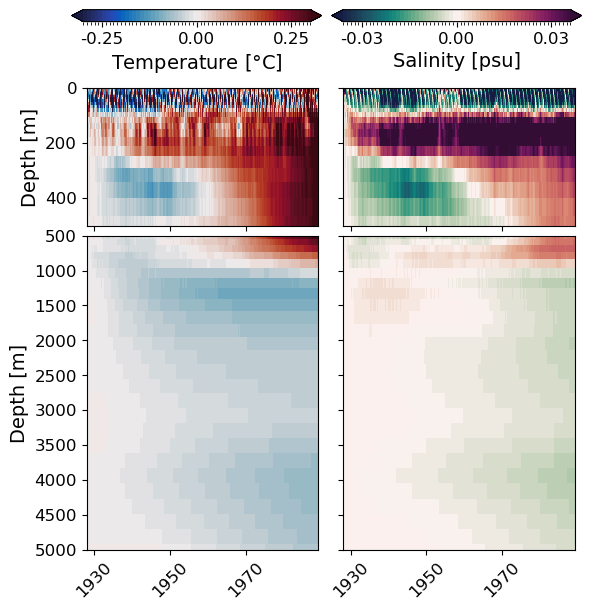

In [11]:
fig, ax = plot_hovmoller(fsize = 14)

levels_temperature = np.arange(-0.3, 0.31, 0.01)

cf_temp = temperature_hov.cf.plot(ax = ax[0],
                                  levels = levels_temperature,
                                  x = 'time',
                                  y = 'vertical',
                                  add_colorbar = False,
                                  label = None,
                                  cmap = cm.balance)

temperature_hov.cf.plot(ax = ax[2],
                        levels = levels_temperature,
                        x = 'time',
                        y = 'vertical',
                        add_colorbar = False,
                        label = None,
                        cmap = cm.balance)

levels_salinity = np.arange(-0.03, 0.031, 0.001)

cf_salt = salinity_hov.cf.plot(ax = ax[1],
                               levels = levels_salinity,
                               x = 'time',
                               y = 'vertical',
                               add_colorbar = False,
                               label = None,
                               cmap = cm.curl)

salinity_hov.cf.plot(ax = ax[3],
                     levels = levels_salinity,
                     x = 'time',
                     y = 'vertical',
                     add_colorbar = False,
                     label = None,
                     cmap = cm.curl)

## Beautification details
for i in range(len(ax)):
    if i < 2:
        ax[i].set_ylim(500, 0)
        ax[i].set_xticklabels([])
    else:
        ax[i].set_xlabel("")
        ax[i].set_ylim(5000, 500)
ax[0].set_ylabel("Depth [m]")
ax[1].set_ylabel("")
ax[2].set_ylabel("Depth [m]")
ax[3].set_ylabel("")

# Colorbars
bar = plt.axes([0.11, 0.99, 0.25, 0.02])
cbar_1 = plt.colorbar(cf_temp, cax = bar, orientation = 'horizontal', extend='both', format= '%.2f')  
cbar_1.set_label("Temperature [$\degree$C]")

bar = plt.axes([0.37, 0.99, 0.25, 0.02])
cbar_2 = plt.colorbar(cf_salt, cax = bar, orientation = 'horizontal', extend='both', format= '%.2f')  
cbar_2.set_label("Salinity [psu]")

for cbar in [cbar_1, cbar_2]:
    tick_locator = ticker.MaxNLocator(nbins=3) ## The ticker needs to called within the loop
    cbar.locator = tick_locator
    cbar.update_ticks()